## Toxicity of League of Legends Gaming Community 
### Bi Nguyen, Kelly Chan, Fenglan Jiang

In [ ]:
#Import libraries
import lxml.html as lx
import pandas as pd
import numpy as np
import requests
import requests_cache
import numpy as np
import nltk
import nltk.corpus
from nltk.corpus import wordnet
from itertools import chain
from plotnine import *
import time
import matplotlib.pyplot as plt
import argparse
from bs4 import BeautifulSoup
from selenium import webdriver
import time
%matplotlib inline
from urllib.parse import urljoin
import re
import argparse
from selenium import webdriver
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import datetime
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
import pyLDAvis.gensim
import warnings
warnings.filterwarnings("ignore")
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from PIL import Image
%matplotlib inline
bokeh.io.output_notebook()

# Extract Data from the Show More forumn

In [6]:
def player_behavior_url(base_url, forum):
    """Get all the urls from the player behaviour forum"""
    requests_cache.install_cache('player_logs')
    url = []
    start = 0 
    while True:
        try:
            time.sleep(.05)
            response = requests.get(forum+str(start))
            response.raise_for_status()
            result = response.json()
            result = result['discussions']
            html = lx.fromstring(result)
            html.make_links_absolute(base_url)
            url += html.xpath("//tr//@data-href")
            start += 50;
        except:
            break
    return url

In [ ]:
driver = webdriver.Chrome("/Users/bitnguyen/Desktop/UC Davis/Winter 2019/STA141B/Final Project/chromedriver")

In [7]:
def op_region_info(region,user_name):
    """Collect a player's level and recent ranking, win and lose streak given the player's region and name"""
    base_op = "https://"+region+".op.gg/summoner/userName="
    requests_cache.install_cache("opna")
    time.sleep(.005)
    response = requests.get(base_op + user_name)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    
    lvl = html.xpath("//*[contains(@class,'Level tip')]")
    recent_rank = html.xpath("//*[contains(@class, 'PastRankList')]/li[last()]")
    win_lose = html.xpath("//*[contains(@class, 'GameResult')]/text()")
    win_count = 0
    lose_count = 0
    if len(win_lose) > 0:
        for result in win_lose:
            if 'Victory' in result:
                win_count +=1
            else:
                lose_count +=1
    else:
        win_count = np.nan
        lose_count = np.nan

    if len(lvl) > 0:
        lvl = lvl[0].text_content().strip()
    
    if len(recent_rank) > 0:
        recent_rank = recent_rank[0].text_content().strip()
        
    if len(lvl) > 0 and len(recent_rank) > 0:
        return recent_rank, lvl, win_count, lose_count
    
    elif len(lvl)>0:
        return np.nan,lvl, win_count, lose_count
    
    else:
        return np.nan, np.nan, win_count, lose_count

In [8]:
def isSameLength(ls,length):
    """Check to make sure all the rows matches in the dataframe
    If they are not in the same length, it will raise an error when creating a dataframe"""
    if len(ls) == length:
        return ls
    else:
        while len(ls) < length:
            ls.append(np.nan)
        else:
            while len(ls) > length:
                ls.pop()
        return ls

In [9]:
def show_more_info(url):
    """Given the url a player's post:
    Extract all information regarding: url, post title, names, region, dates when the post was posted,
    member type, likes, rank, level, win and lose"""
    tier = []
    level = []
    win = []
    lose = []
    driver.get(url)
    time.sleep(0.05)
    requests_cache.install_cache('show_more_info')
    html = lx.fromstring(driver.page_source)
    try:#all posts has a title, so if no title means the url gives bad input
        title = html.xpath("//*[@data-bind = 'text: title']")[0].text_content()
    except:
        return
    name = html.xpath("//span[@class = 'username']/text()")
    region = [html.xpath("//span[contains(@class, 'realm')]")[0].text_content().strip("/(/)")] + html.xpath("//span[contains(@class, 'realm')]/span/text()")
    date = html.xpath("//div[@class = 'author-info byline']/span/@title") + html.xpath("//span[@class = 'timeago']/span/@title") 
    likes = html.xpath("//li[@class = 'total-votes']/text()")
    post = [html.xpath("//*[@id='content']/div[1]")[0].text_content()]
    try:
        replies = [x.text_content() for x in html.xpath("//*[@class='high-quality markdown']")]
    except:
        replies = []
    replies = isSameLength(replies, len(name)-1)
    likes = isSameLength(likes, len(name))
    text = post + replies    
    title = [title] * len(name)
    date = isSameLength(date, len(name))
    region = isSameLength(region,len(name))
    for i in range(len(name)):
        value = op_region_info(region[i], name[i])
        tier.append(value[0])
        level.append(value[1])
        win.append(value[2])
        lose.append(value[3])
    return pd.DataFrame({"url": url, "title":title, "name": name, "region": region, "tier": tier, "level": level, 
                         "date": date, "text": text, "likes": likes, "win": win, "lose": lose})

In [10]:
def region_info(region_base_url, region_extension):
    """Combine previous functions to collect information from all the players
        in a particular region"""
    #Get all the urls from a region
    region_urls = player_behavior_url(region_base_url, urljoin(region_base_url,region_extension))
    region_urls = [urljoin(region_base_url, url) for url in region_urls]
    #Extract information from the region
    return [show_more_info(url) for url in region_urls]

**Below is the base URL and Extension of each region**

In [11]:
#North America
na_base_url_regions = "https://boards.na.leagueoflegends.com"
na_extension_regions = "api/ZGEFLEUQ/discussions?sort_type=hot&num_loaded="

#European West/East -> Under the show more forumn EUNE and EUW are both the same
euw_base_url_regions = "https://boards.euw.leagueoflegends.com"
euw_extension_regions = "api/NzaqEm3e/discussions?sort_type=hot&num_loaded="

#OCEANIA 
oce_base_url_regions = "https://boards.oce.leagueoflegends.com"
oce_extension_regions = "api/T8eq2lFQ/discussions?sort_type=hot&num_loaded="

In [97]:
#Get all the regions (list of dataframes)
show_more_na = region_info(na_base_url_regions, na_extension_regions)
show_more_euw = region_info(euw_base_url_regions,euw_extension_regions)
show_more_oce = region_info(oce_base_url_regions,oce_extension_regions)

In [255]:
#Turn into dataframe
show_more_na_df = pd.concat(na)
show_more_euw_df = pd.concat(euw)
show_more_oce_df = pd.concat(oce)

#Merge data
show_more_regions = pd.concat([show_more_na_df, show_more_euw_df, show_more_oce_df]).reset_index()
show_more_regions['date'] = pd.to_datetime(show_more_regions['date'])
show_more_regions.columns.values[0] = 'tree'
show_more_regions.to_dense().to_csv("show_more_forum.csv", index = False, sep=',', encoding='utf-8')

,tree,title,name,region,tier,level,date,text,likes,win,lose
0,0,Ten reasons why it's better not to flame back,Tuition Fee,NA,S8 Silver,190,2019-03-01T01:47:25.413+0000,Flamers usually get even madder when you don't...,35,3.0,7.0
1,1,Ten reasons why it's better not to flame back,AngusBoomPants,NA,S8 Gold,136,2019-03-01T03:38:23.091+0000,It's not worth your time. In the time you were...,15,7.0,3.0
2,2,Ten reasons why it's better not to flame back,Tuition Fee,NA,S8 Silver,190,2019-03-01T03:47:31.350+0000,"Only takes 1 second to type ""no u""\nI meanYou'...",6,3.0,7.0
3,3,Ten reasons why it's better not to flame back,Basstaper,EUW,S6 Silver,65,2019-03-01T11:37:35.433+0000,"Only takes 1 second to type ""no u""\nI said tha...",3,6.0,4.0
4,4,Ten reasons why it's better not to flame back,General Matty,NA,S8 Silver,96,2019-03-01T12:52:12.728+0000,"Only takes 1 second to type ""no u""\nWhat if th...",2,2.0,2.0
5,5,Ten reasons why it's better not to flame back,AngusBoomPants,NA,S8 Gold,136,2019-03-02T04:08:25.755+0000,What if they say ''reverse''? :^)\nI'm afk,1,7.0,3.0
6,6,Ten reasons why it's better not to flame back,Bob the Toastr,NA,S8 Gold,175,2019-03-01T14:35:15.562+0000,"Then you must respond with ""cha cha now y'all,...",1,8.0,2.0
7,7,Ten reasons why it's better not to flame back,TrulyBland,EUNE,S7 Silver,30,2019-03-01T14:58:32.481+0000,"If in doubt, say ""How appropriate, you fight l...",1,NaN,NaN
8,8,Ten reasons why it's better not to flame back,PurpleYukari,NA,S5 Bronze,43,2019-03-01T02:07:00.943+0000,11. You are making the flamer's flame feel mo...,12,NaN,NaN
9,9,Ten reasons why it's better not to flame back,R107 Games,NA,NaN,13,2019-03-01T02:51:14.415+0000,Flamers usually get even madder when you don't...,-14,NaN,NaN


# Extract the pages forumn

In [12]:
def get_page_url(base_url, page_url):
    """Collect all urls from the pages forum, each page containing 50 urls"""
    requests_cache.install_cache('page_logs')
    cur_page = 1;
    urls = []
    while True:
        try:
            time.sleep(.05)
            response = requests.get(page_url+str(cur_page))
            html = lx.fromstring(response.text)
            html.make_links_absolute(base_url)
            url = html.xpath("//tbody//td/a/@href")
            urls += url
            cur_page +=1;
            if cur_page > 20: #Get at most 1000 urls so that we can have the same distribution as the number of urls in the other forumn
                break
        except:
            break
    return urls

In [13]:
def op_pages_info(op_url, name):
    """Given the url from the player's statistics, and their names
    Collect information about their ranks, and level since the actual website does not
    include these information"""
    requests_cache.install_cache("opna")
    time.sleep(.005)
    response = requests.get(op_url+name)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    
    lvl = html.xpath("//*[contains(@class,'Level tip')]")
    recent_rank = html.xpath("//*[contains(@class, 'PastRankList')]/li[last()]")
    if len(lvl) > 0:
        lvl = lvl[0].text_content().strip()
    
    if len(recent_rank) > 0:
        recent_rank = recent_rank[0].text_content().strip()
        
    if len(lvl) > 0 and len(recent_rank) >0:
        return recent_rank,lvl
    
    elif len(lvl)>0:
        return np.nan,lvl
    else:
        return np.nan, np.nan 

In [14]:
def page_info(url,op_url):
    """Given the url from the LoL forumn and the url from the player's statistics
    Extract all information regarding: url, post title, names, region, dates when the post was posted,
    member type, likes, rank, level"""
    dates = []
    names = []
    members = []
    texts = []
    lvl = []
    rank = []
    likes = []
    requests_cache.install_cache("page_posts") 
    try:
        response = requests.get(url)
        response.raise_for_status()
        html = lx.fromstring(response.text)
        time.sleep(.05)
        like = html.xpath("//*[contains(@class, 'post-rating padding-side-10')]")
        title = html.xpath("//*[contains(@class, 'float-left')]/h3")[0].text_content()
        all_dates = html.xpath("//*[contains(@class, 'post-header padding-side-10 clearfix')]")
        all_users = html.xpath("//*[contains(@class, 'post-user')]")
        member_type = html.xpath("//*[contains(@class, 'post-col-left')]//p")[1::2]
        region = [op_url.split('//')[1].split('.')[0].upper()] * len(all_dates)
        #Because region is not specified in the pages forum, assume that whichever region on iterating, use
        #that region as main region
        for i in range(len(all_dates)):
            dates.append(all_dates[i].text_content().strip())
            names.append(all_users[i].text_content().strip())
            members.append(member_type[i].text_content().strip())
            texts.append(html.xpath("//*[contains(@class,'post-message')]")[i].text_content().strip())
            likes.append(like[i].text_content().strip('+'))
        for name in names:
            op_na = op_pages_info(op_url,name)
            rank.append(op_na[0])
            lvl.append(op_na[1])
        return pd.DataFrame({'url': url, 'title': title,'name':names,"region": region,"tier": rank, "level": lvl, 'date': dates,  'text':texts, 'likes': likes, 'member_type': members,})
    except:
        return

In [15]:
def pages_info(region_base_url, region_extension, region_op_url):
    """Given the parameters for the LoL urls, get all the urls and
    from the url, get all the players information from each url"""
    region_pages_url = get_page_url(region_base_url, region_base_url + region_extension)
    region_pages_url = list(set(region_pages_url))
    return [page_info(url, region_op_url) for url in region_pages_url]

**Base website and extension to get the pages forumn**



In [11]:
#NA 
na_base_url_pages = "http://forums.na.leagueoflegends.com/"
na_extension_pages = "board/forumdisplay.php?f=59&page="
na_op_url = "https://na.op.gg/summoner/userName="

#EUW
euw_base_url_pages = "http://forums.euw.leagueoflegends.com/"
euw_extension_pages = "board/forumdisplay.php?f=85&page="
euw_op_url = "https://euw.op.gg/summoner/userName="

#EUNE
eune_base_url_pages = "http://forums.eune.leagueoflegends.com/"
eune_extension_pages = "board/forumdisplay.php?f=85&page="
eune_op_url = "https://eune.op.gg/summoner/userName="

#OCE
oce_base_url_pages = "http://forums.oce.leagueoflegends.com/"
oce_extension_pages = "board/forumdisplay.php?f=59&page="
oce_op_url = "https://oce.op.gg/summoner/userName="

In [30]:
na_pages = pages_info(na_base_url_pages, na_extension_pages, na_op_url)
eune_pages = pages_info(eune_base_url_pages,eune_extension_pages,eune_op_url)
euw_pages = pages_info(euw_base_url_pages,euw_extension_pages,euw_op_url)
oce_pages = pages_info(oce_base_url_pages,oce_extension_pages,oce_op_url)

http://forums.euw.leagueoflegends.com/board/showthread.php?t=1987389
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2104933
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1979826
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2096406
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2049918
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2090782
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2086453
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2036954
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1986005
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2036025
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1999518
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2077391
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2059975
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2071469
http://forums.euw.leagueoflegends.

http://forums.euw.leagueoflegends.com/board/showthread.php?t=2083703
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2056204
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1622322
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2056950
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2081921
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2040826
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2102234
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2094091
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2104084
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2029690
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2047831
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2001469
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1977144
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1978800
http://forums.euw.leagueoflegends.

http://forums.euw.leagueoflegends.com/board/showthread.php?t=1995249
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2051003
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2018748
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1993291
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2013639
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1979190
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2075762
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2041243
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2008827
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2076125
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1986439
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1983323
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2089655
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2061754
http://forums.euw.leagueoflegends.

http://forums.euw.leagueoflegends.com/board/showthread.php?t=788232
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2093255
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2081559
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2091424
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2069073
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2004599
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2044729
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2045301
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2086172
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1988947
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2067819
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2002179
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2034331
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1995828
http://forums.euw.leagueoflegends.c

http://forums.euw.leagueoflegends.com/board/showthread.php?t=2044168
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2097121
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2091428
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1979254
http://forums.euw.leagueoflegends.com/board/showthread.php?t=546102
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2067471
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2024677
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2097516
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1979276
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2048183
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2088067
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1999877
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2029298
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1985970
http://forums.euw.leagueoflegends.c

http://forums.euw.leagueoflegends.com/board/showthread.php?t=2094471
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2088086
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1999974
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2067990
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2027249
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2094833
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1989618
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1982401
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1993580
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2100922
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2060292
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2084268
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2096545
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2050765
http://forums.euw.leagueoflegends.

http://forums.euw.leagueoflegends.com/board/showthread.php?t=2079471
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2031290
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2097823
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2004101
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1995846
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1261315
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2100316
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2097219
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2068495
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1982708
http://forums.euw.leagueoflegends.com/board/showthread.php?t=214080
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2076498
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2044542
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2046375
http://forums.euw.leagueoflegends.c

http://forums.euw.leagueoflegends.com/board/showthread.php?t=1984690
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1978805
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2010718
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2051465
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2045370
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2076186
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1786562
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1981943
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2096053
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1997051
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1995188
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2034075
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2001088
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2089694
http://forums.euw.leagueoflegends.

http://forums.euw.leagueoflegends.com/board/showthread.php?t=1978823
http://forums.euw.leagueoflegends.com/board/showthread.php?t=872650
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2071277
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2041023
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2000227
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1980740
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2057928
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1909977
http://forums.euw.leagueoflegends.com/board/showthread.php?t=1989342
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2103586
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2057269
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2037684
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2045053
http://forums.euw.leagueoflegends.com/board/showthread.php?t=2057922
http://forums.euw.leagueoflegends.c

http://forums.oce.leagueoflegends.com/board/showthread.php?t=87726
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87302
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87228
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87127
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87284
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88318
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88337
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87572
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87648
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87521
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87916
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87314
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88335
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88247
http://forums.oce.leagueoflegends.com/board/showthread.php?t=8

http://forums.oce.leagueoflegends.com/board/showthread.php?t=88010
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87918
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87298
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87955
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87345
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88271
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87908
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87851
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87706
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87417
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88343
http://forums.oce.leagueoflegends.com/board/showthread.php?t=86444
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88371
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88121
http://forums.oce.leagueoflegends.com/board/showthread.php?t=8

http://forums.oce.leagueoflegends.com/board/showthread.php?t=87945
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87641
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87717
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87681
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87503
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87504
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87266
http://forums.oce.leagueoflegends.com/board/showthread.php?t=69189
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88070
http://forums.oce.leagueoflegends.com/board/showthread.php?t=57077
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88129
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87842
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87542
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87327
http://forums.oce.leagueoflegends.com/board/showthread.php?t=8

http://forums.oce.leagueoflegends.com/board/showthread.php?t=87336
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87197
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88036
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87204
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88065
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87976
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87841
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87654
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87852
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87277
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87225
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88037
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87657
http://forums.oce.leagueoflegends.com/board/showthread.php?t=85855
http://forums.oce.leagueoflegends.com/board/showthread.php?t=8

http://forums.oce.leagueoflegends.com/board/showthread.php?t=87994
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87257
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87285
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87511
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87846
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87707
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87374
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87348
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88231
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87619
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88025
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87607
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87268
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87344
http://forums.oce.leagueoflegends.com/board/showthread.php?t=8

http://forums.oce.leagueoflegends.com/board/showthread.php?t=16684
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87938
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88258
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87539
http://forums.oce.leagueoflegends.com/board/showthread.php?t=66595
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87455
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87890
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87467
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87505
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87355
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87154
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87829
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88327
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88304
http://forums.oce.leagueoflegends.com/board/showthread.php?t=8

http://forums.oce.leagueoflegends.com/board/showthread.php?t=88403
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88280
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87678
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87927
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88082
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87806
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87248
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87354
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87426
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88184
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87797
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88208
http://forums.oce.leagueoflegends.com/board/showthread.php?t=16186
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87894
http://forums.oce.leagueoflegends.com/board/showthread.php?t=8

http://forums.oce.leagueoflegends.com/board/showthread.php?t=88075
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87534
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87183
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87944
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88291
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87655
http://forums.oce.leagueoflegends.com/board/showthread.php?t=773
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88276
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88190
http://forums.oce.leagueoflegends.com/board/showthread.php?t=86262
http://forums.oce.leagueoflegends.com/board/showthread.php?t=50544
http://forums.oce.leagueoflegends.com/board/showthread.php?t=88160
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87821
http://forums.oce.leagueoflegends.com/board/showthread.php?t=87671
http://forums.oce.leagueoflegends.com/board/showthread.php?t=876

In [31]:
#Turn into dataframe
euw_pages_df = pd.concat(euw_pages)
eune_pages_df = pd.concat(eune_pages)
na_pages_df = pd.concat(na_pages)
oce_pages_df = pd.concat(oce_pages)

In [41]:
#Merge data
pages_regions = pd.concat([na_pages_df,euw_pages_df,eune_pages_df,oce_pages_df], join = 'inner').reset_index()
pages_regions.columns.values[0] = 'tree'
pages_regions.to_dense().to_csv("pages_forum_limit_1000.csv", index = False, sep=',', encoding='utf-8')

In [42]:
#Convert to appropriate data types
pages_regions['level'] = pages_regions['level'].astype(float)
pages_regions['dates'] = pd.to_datetime(pages_regions['dates'])
pages_regions['likes'] =  pages_regions['likes'].astype(float)

**Our defined definition of toxic words including possible abbreviation that a player might use**

In [ ]:
toxic_words = [
    'fuck', 'shit', 'bitch', 'nigga', 'hate', 'suck', 'ass', 'lame', 'whore', 'slut', 
    'dick','noob', 'chicken', 'report', 'troll', 'waste', 'idiot',
    'stupid', 'dumb', 'fool','minor','feed', 'fault', 'carry', 'butthurt', 
    'sissy', 'disguisting', 'logic', 'stop', 'childish','retard', 'die','annoy','piss',
    'rage','mentally ill', 'mute','bad', 'unskill', 'boost', 'toast', 'poorly', 'bullshit', 'fake',
    'ruin', 'delete','hell','gay', 'ban', 'lose', 'flame', 'loser', 'sensitive', 
    'garbage', 'trash', 'toxic', 'nibba', 'ggez', 'easy', 'trigger', 'fragile', 'pussy', 'kill', 
    'crybaby', 'worthless', 'feeding', 'braincell', 'degenerate', 'cancer',
    'low elo', 'fag', 'kid', 'uninstall', 'wooden pc', 'lost', 'heavy','flamer', 'smurf', 'open',
    'mad', 'dodge', 'flamed', 'normal', 'jew', 'tilt', 'titled','braindead', 'dickface',
    'scum','mom', 'monkey', 'burn', 'better', 'end', 'quit', 'hang', 'spam', 'ping', 'refund',
    'jerk', 'asshole', 'bronze', 'down syndrome', 'why', 'mentally disable', 'slit', 'cunt','grief']

abbreviation = ['bruh', 'lol', 'xd', 'wtf', 'wth', 'stfu', '*', 'ff', 'int', 
                'inting', 'kys', 'gg', 'smurf', 'afk', '..', 'mia', 'ffs',
                'kms', 'smh', 'fuk', 'ks', 'fck', 'fk', 'rekt', 'rek', 'ez', 'omfg']

In [16]:
def name_type(_type):
    """Attempts to convert words into its root word for better frequency count"""
    if _type.startswith('V'):
        return wordnet.VERB
    elif _type.startswith('R'):
        return wordnet.ADV
    elif _type.startswith('J'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN

def adj_words(text,abbreviation):
    """Attempts to remove unnessary words from a text"""
    ls = []
    words = text.lower()
    lemantizer = nltk.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words("english")
    p = nltk.word_tokenize(words)
    p = [word for word in p if word.isalnum() and (''.join(word)).strip() not in stopwords]    
    word_tags = nltk.pos_tag(p)
    for word, ntype in word_tags:
        if word in abbreviation:
            ls.append(word)
        else:
            ls.append(lemantizer.lemmatize(word,name_type(ntype)))     
    return ls

def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    return table.get(tag[0], wordnet.NOUN)

def toxic_words_in_text(doc,toxic_words):
    """Collect the toxic words in a text"""
    words = nltk.word_tokenize(str(doc).lower())
    lemmatizer = nltk.WordNetLemmatizer()
    tags =  nltk.pos_tag(words)
    words = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in tags]
    stopwords = [w for w in words if w in toxic_words and w.isalnum()] 
    return stopwords

def word_count(text,stopwords):    
    count = 0
    for word in stopwords:
        if word in text.lower():
            count +=1
    return count

def remove_dup_text(text):
    if re.search("\(\w{2,5}\)",text):
        text = ''.join(text.split('\n\n')[1:])
    return text

def clean_text_pages(text):
    done = False
    count = 0
    if str(text).startswith('Quote'):
        while not done and count < 2:
            copy_text= ''.join(text.split('\r\n')[1:]).strip()
            if len(copy_text) > 0:
                done = True
            else:
                copy_text = ''.join(text.split('\n\n')[1:]).strip()
                count +=1
        text = copy_text
    return text

**Read the csv files instead of rerunning the csv file**

In [ ]:
# CSV files:
pages_regions = pd.read_csv("/Users/bitnguyen/Desktop/UC Davis/Winter 2019/STA141B/Final Project/pages_forum_limit_1000.csv")
pages_regions['region'] = pages_regions['region'].apply(str)
pages_regions['region'] = pages_regions['region'].replace('nan', 'NA')

show_more_regions = pd.read_csv("/Users/bitnguyen/Desktop/UC Davis/Winter 2019/STA141B/Final Project/show_more_forum.csv")
show_more_regions['region'] = show_more_regions['region'].apply(str)
show_more_regions['region'] = show_more_regions['region'].replace('nan', 'NA')

In [17]:
# Clean the text and get the word count:
show_more_regions['cleaned_text'] = show_more_regions['text'].apply(lambda x: remove_dup_text(str(x)).strip())
show_more_regions['word_count'] = show_more_regions['cleaned_text'].apply(lambda x: word_count(x,toxic_words+abbreviation))
show_more_regions_copy = show_more_regions.copy()

#Merge the pages dataframe and the show more dataframe
show_more_regions_copy['date'] = pd.to_datetime(show_more_regions_copy['date'])
show_more_regions_copy['date'] = show_more_regions_copy['date'].dt.date
pages_regions['cleaned_text'] = pages_regions['text'].apply(lambda x: clean_text_pages(str(x)))
pages_regions['word_count'] = pages_regions['cleaned_text'].apply(lambda x: word_count(x,toxic_words+abbreviation))
pages_regions.columns.values[6] = 'date'
combined_df = pd.concat([show_more_regions_copy,pages_regions], join = 'inner')
combined_df

,tree,title,name,region,tier,level,date,text,likes,cleaned_text,word_count
0,0,Ten reasons why it's better not to flame back,Tuition Fee,NA,S8 Silver,190.0,2019-03-01,\nFlamers usually get even madder when you don...,35.0,Flamers usually get even madder when you don't...,17
1,1,Ten reasons why it's better not to flame back,AngusBoomPants,NA,S8 Gold,136.0,2019-03-01,\nIt's not worth your time. In the time you we...,15.0,It's not worth your time. In the time you were...,2
2,2,Ten reasons why it's better not to flame back,Tuition Fee,NA,S8 Silver,190.0,2019-03-01,\nAngusBoomPants (NA) - 11 days ago\nOnly take...,6.0,I meanYou're not wrong,0
3,3,Ten reasons why it's better not to flame back,Basstaper,EUW,S6 Silver,65.0,2019-03-01,\nAngusBoomPants (NA) - 11 days ago\nOnly take...,3.0,"I said that once, and funny enough the guy fla...",2
4,4,Ten reasons why it's better not to flame back,General Matty,NA,S8 Silver,96.0,2019-03-01,\nAngusBoomPants (NA) - 11 days ago\nOnly take...,2.0,What if they say ''reverse''? :^),0
5,5,Ten reasons why it's better not to flame back,AngusBoomPants,NA,S8 Gold,136.0,2019-03-02,\nGeneral Matty (NA) - 10 days ago\nWhat if th...,1.0,I'm afk,2
6,6,Ten reasons why it's better not to flame back,Bob the Toastr,NA,S8 Gold,175.0,2019-03-01,"Then you must respond with ""cha cha now y'all,...",1.0,"Then you must respond with ""cha cha now y'all,...",0
7,7,Ten reasons why it's better not to flame back,TrulyBland,EUNE,S7 Silver,30.0,2019-03-01,"If in doubt, say ""How appropriate, you fight l...",1.0,"If in doubt, say ""How appropriate, you fight l...",0
8,8,Ten reasons why it's better not to flame back,PurpleYukari,NA,S5 Bronze,43.0,2019-03-01,11. You are making the flamer's flame feel mo...,12.0,11. You are making the flamer's flame feel mo...,3
9,9,Ten reasons why it's better not to flame back,R107 Games,NA,NaN,13.0,2019-03-01,\nTuition Fee (NA) - 11 days ago\n\nFlamers us...,-14.0,Flamers usually get even madder when you don't...,21


# Make frequency plot for the common toxic words from the combined dataframe



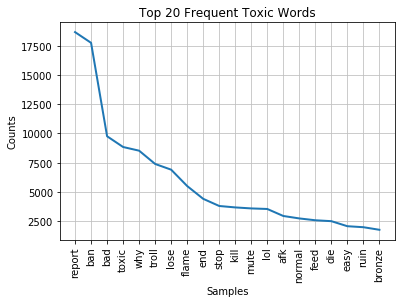

In [160]:
#Make frequency plot for the common toxic words from the show more dataframe and pages dataframe
toxic = [toxic_words_in_text(doc,toxic_words + abbreviation) for doc in combined_df['cleaned_text']]
toxic = [w for sublist in toxic for w in sublist]
toxic_fq = nltk.FreqDist(w for w in toxic if w.isalnum())
toxic_fq.most_common(50)
toxic_fq.plot(20, title = 'Top 20 Frequent Toxic Words')

# Creat a Wordcloud for toxic words


In [158]:
#Make a copy of the cleaned dataframe and continue extracting 
copy_combined_df = combined_df.copy()
copy_combined_df['tier'] = copy_combined_df['tier'].str.strip('S4|S5|S6|S7|S8')

In [161]:
#Gather the main words from all of the text:
all_words = ' '.join(toxic)

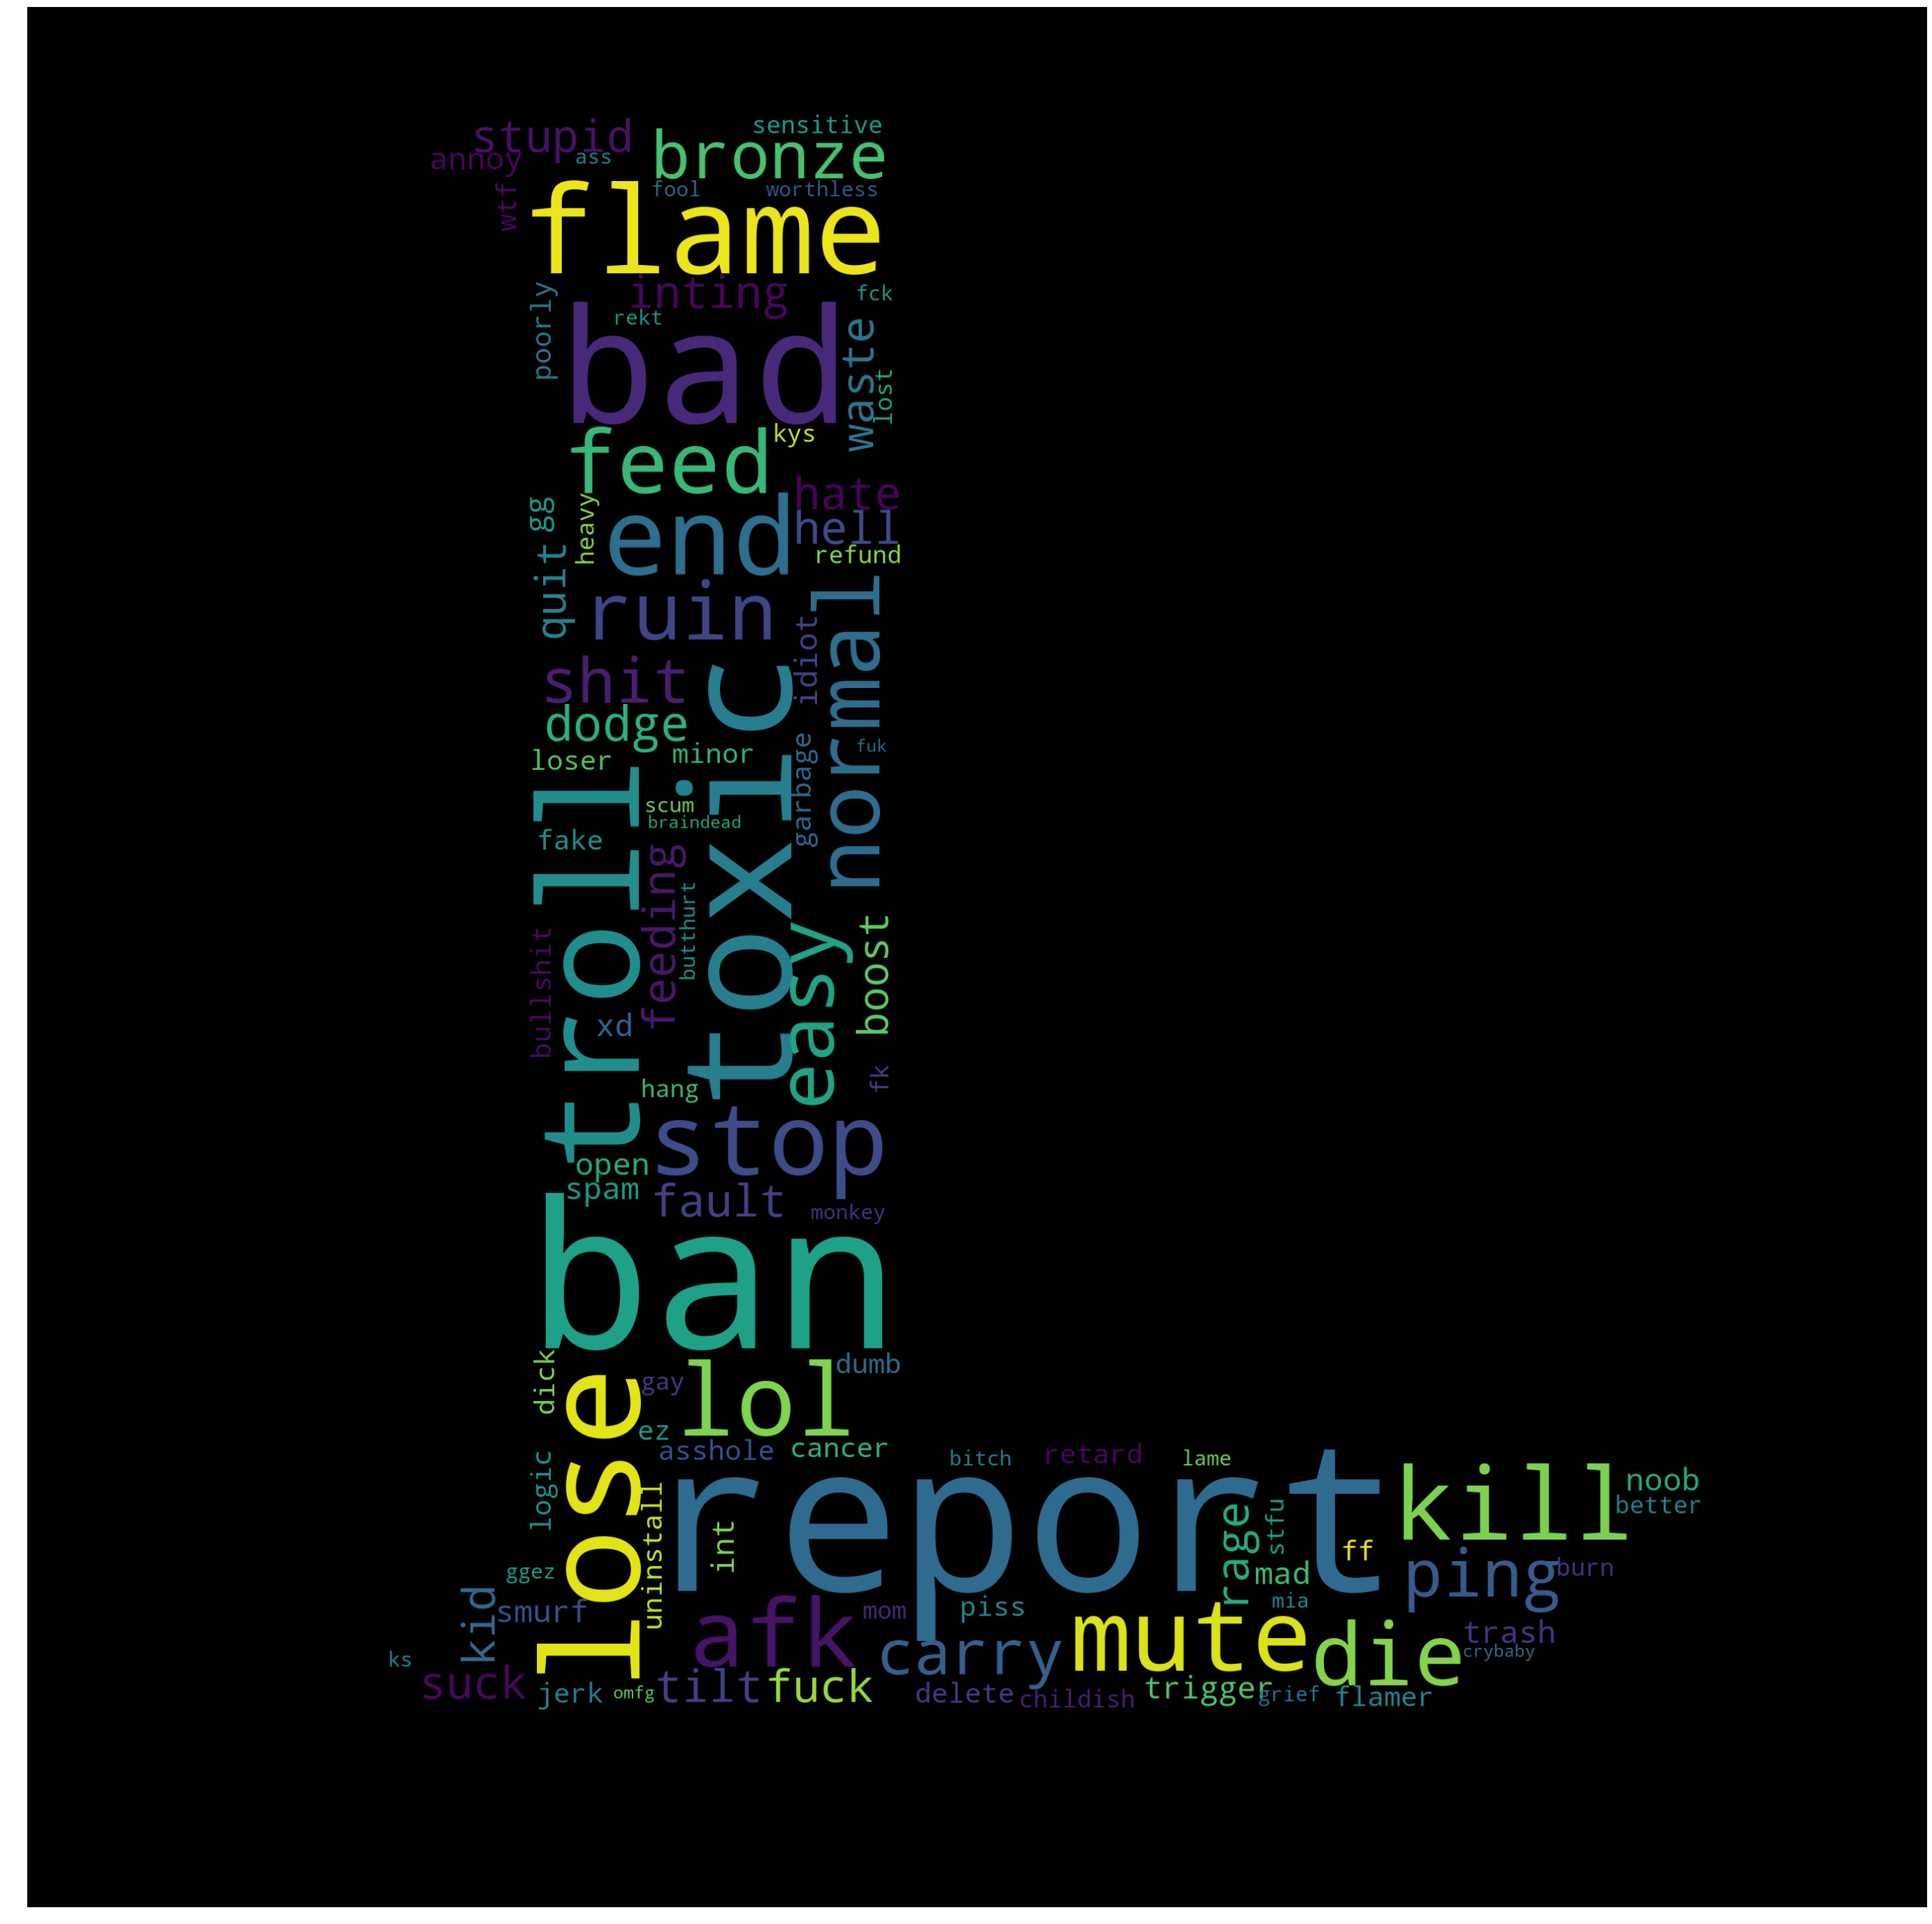

In [84]:
#WordCloud of all the frequent words in the text:
open_mask = np.array(Image.open("/Users/bitnguyen/Desktop/UC Davis/Winter 2019/STA141B/Final Project/Pictures/lol.png"))
wordcloud = WordCloud(
    collocations = False,
    background_color='black',
    width=500, height=300,
    max_words= 100,
    max_font_size = 60, 
    scale=5,
    mask = open_mask
    ).generate(str(all_words))

#Display the wordcloud
fig = plt.figure(figsize=(55, 50))
plt.axis('off')
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()
wordcloud.to_file('wordcloud.png')

**Analyzing frequency of toxic words from each tier**

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Tier'),
 Text(0.5, 1.0, 'Toxic Words Freq of Regions')]

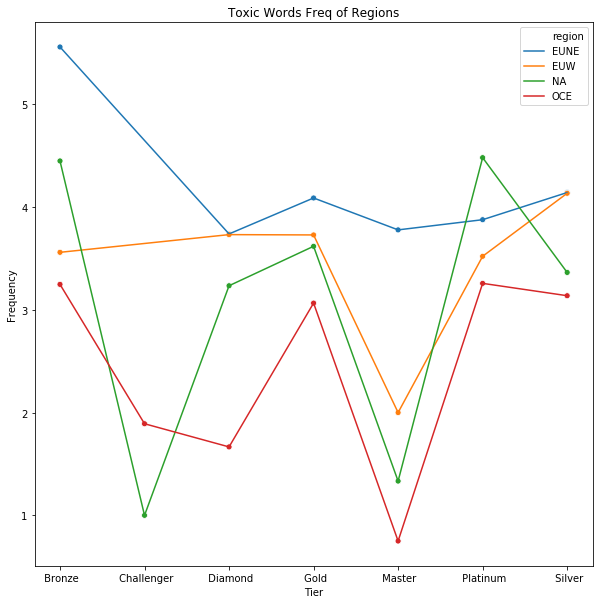

In [86]:
tier_analysis = copy_combined_df.groupby(["tier","region"])["word_count"].mean()
tier_analysis= tier_analysis.reset_index()

#Create lineplot for the tier Frequency
plt.rcParams["figure.figsize"] = [10, 10]
ax = sns.scatterplot(x= 'tier', y= 'word_count',hue ='region', data = tier_analysis, legend=False)
ax = sns.lineplot(x = 'tier', y = "word_count", hue ='region',data = tier_analysis)
#ax.set_xticklabels("Bronze, Silver, Gold, Platinum, Diamond, Master, Challenger")
ax.set(title = "Toxic Words Freq of Regions", xlabel = "Tier", ylabel = "Frequency")

ax.savefig("lineplot_toxic_word_freq")

**Looking at possible discrepency between the ranks**

In [193]:
pd.DataFrame(copy_combined_df.groupby(["tier","region"])["word_count"].count())

word_count
tier        region            
 Bronze     EUNE           321
            EUW            699
            NA            1431
            OCE           1548
 Challenger NA               1
            OCE             92
 Diamond    EUNE           642
            EUW            857
            NA             222
            OCE            440
 Gold       EUNE          2981
            EUW           3802
            NA            2943
            OCE           2614
 Master     EUNE             9
            EUW              2
            NA               9
            OCE              4
 Platinum   EUNE           836
            EUW           2406
            NA             745
            OCE           2141
 Silver     EUNE          3874
            EUW           3351
            NA            5261
            OCE           4607

**Analyze the time that players tend to post**

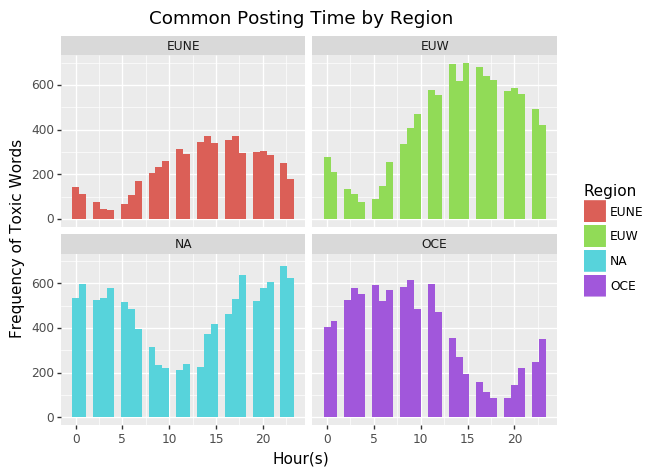

<ggplot: (-9223372029293902855)>

In [152]:
copy_show_more = show_more_regions.copy()
copy_show_more['tier'].groupby(copy_show_more['tier']).count()
copy_show_more['date'] = pd.to_datetime(copy_show_more['date'])
copy_show_more['hour'] = copy_show_more.date.apply(lambda x: x.hour)
copy_show_more['region'] = copy_show_more['region'].str.replace('NaN', 'NA')

p1 = (
    ggplot(copy_show_more, aes(x= "hour", fill = 'region' )) + geom_histogram() + facet_wrap('region') +
    labs(x="Hour(s)", y="Frequency of Toxic Words", title = "Common Posting Time by Region", fill = "Region")
)
p1.save("post_time.png")
p1

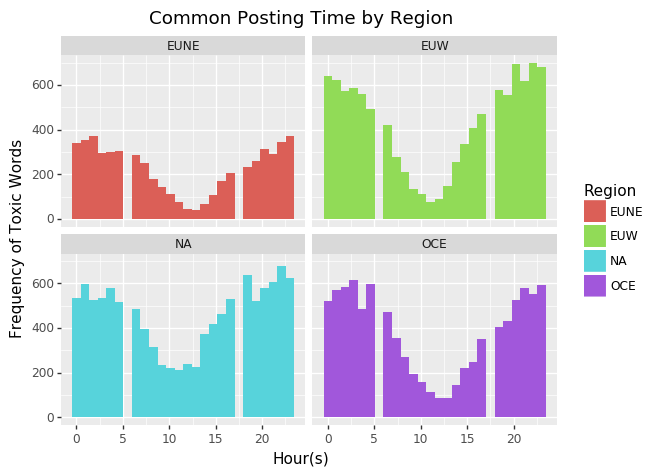

<ggplot: (7592782789)>

In [153]:
def convert_time(region, hour):
    """Converting the Pacific Time Zone to a region's specific timezone"""
    if region == 'EUW':
        if hour + 7 > 23:
            return hour + 7 - 24
        else:
            return hour + 7
    elif region == 'EUNE':
        if hour + 9 > 23:
            return hour + 9 - 24
        else:
            return hour + 9
    elif region == 'OCE':
        if hour + 18 > 23:
            return hour + 18 - 24
        else:
            return hour + 18
    else:
        return hour

copy_show_more['new_hour'] = copy_show_more.apply(lambda x: convert_time(x.region, x.hour), axis =1)
p2 = (
    ggplot(copy_show_more, aes(x= "new_hour", fill = 'region' )) + geom_histogram() + facet_wrap('region') +
    labs(x="Hour(s)", y="Frequency of Toxic Words", title = "Common Posting Time by Region", fill = "Region")
)
p2.save("post_time2.png")
p2

**Note**

OCE is ahead by 18 hours
EUW is ahead 7 hours
EUNE is ahead 9 hours
By converting the time differences, not shown on the graph. We can see that in North America, toxic plyaers are more active in the forumns around evening to the middle of the night. Converting Europe North eastern timezone to Pacific Time Zone, toxic players are more active around  the evening. Same thing applies to Europe west. Oceania toxic players are more active from the morning to the afternoon. 

**Create a proportion table to analyze the trend of toxic words based on the post**

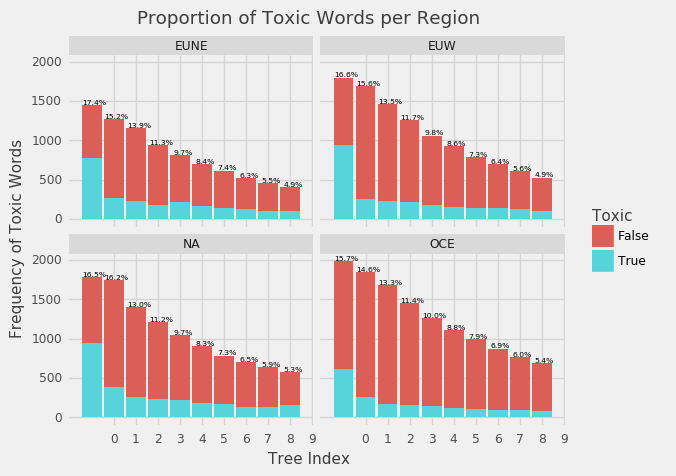

<ggplot: (7603685075)>

In [247]:
total_avg_word_count = int(copy_combined_df.groupby("word_count")["tree"].mean().mean())
copy_combined_df['is_toxic'] = copy_combined_df['word_count'].apply(lambda x: x >= total_avg_word_count)

p3  = (ggplot(copy_combined_df[copy_combined_df['tree'] < 10], aes('tree', fill='is_toxic'))
 + geom_bar()
 
 + geom_text(
     aes(label='stat(100*prop)', group = 1),
     stat='count',
     nudge_y=.4,
     nudge_x = .125,
     va='bottom',
     size= 5.525,
     format_string='{:.1f}%'
 )
 + facet_wrap('region') + theme_538() +
      labs(x= "Tree Index", y = "Frequency of Toxic Words", 
           title = "Proportion of Toxic Words per Region", fill = "Toxic")
 +
       scale_x_discrete(limits = [x for x in range(10)])
)
 
p3.save("proportion plot.png")
p3


In [214]:
copy_combined_df.dtypes

tree              int64
title            object
name             object
region           object
tier             object
level           float64
date             object
text             object
likes           float64
cleaned_text     object
word_count        int64
is_toxic           bool
dtype: object

In [18]:
def process_text(text):
    """Parameter: a set of text
        This function attempts to clean the text by turning
        the words into its root words"""
    en_stop = nltk.corpus.stopwords.words("english")
    text_set = list(text)
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for text in text_set:
        # clean and tokenize document string
        words = nltk.word_tokenize(str(text).lower())
        lemmatizer = nltk.WordNetLemmatizer()
        tags =  nltk.pos_tag(words)
        words = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in tags]
        # remove stop words from tokens
        stopped_tokens = [word for word in words if not word in en_stop and word.isalpha() and len(word) >= 3]
        # add tokens to list
        texts.append(stopped_tokens)
    return texts

In [19]:
#Make a term matrix to evaluate the texts
texts = process_text(combined_df['cleaned_text'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

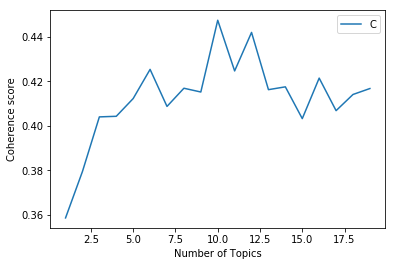

In [203]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """Create a coherence value plot to evaluate the lda model, returns:
        lm_list : List of LDA topic models
        c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("Conference Values"), loc= 'best')
    plt.savefig("coherence_plot.png")
    plt.show()
    return lm_list, c_v

lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts= texts, limit= 20)

**From the coherence model, we choose the topic number that best fit the LDA Model**

In [197]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes= 50)
print(ldamodel.print_topics(num_topics=7, num_words=5))

[(2, '0.091*"ban" + 0.083*"get" + 0.064*"chat" + 0.027*"restriction" + 0.026*"game"'), (6, '0.045*"chat" + 0.044*"mute" + 0.044*"ping" + 0.040*"dodge" + 0.024*"button"'), (7, '0.037*"account" + 0.037*"http" + 0.035*"riot" + 0.018*"new" + 0.015*"use"'), (1, '0.366*"report" + 0.060*"name" + 0.027*"remove" + 0.022*"forum" + 0.021*"post"'), (5, '0.027*"team" + 0.019*"get" + 0.018*"game" + 0.016*"enemy" + 0.015*"play"'), (0, '0.043*"game" + 0.026*"people" + 0.022*"get" + 0.021*"play" + 0.020*"like"'), (3, '0.140*"support" + 0.062*"ticket" + 0.056*"send" + 0.026*"riot" + 0.025*"request"')]


In [198]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.186750  0.012584       1        1  23.221304
4      0.200817  0.011535       2        1  14.832880
5      0.144837 -0.032750       3        1  14.055070
8      0.155545 -0.028318       4        1  14.008633
9      0.128910  0.026942       5        1  12.338388
2      0.067010  0.032978       6        1   9.392663
7     -0.026623 -0.045738       7        1   6.285649
1     -0.267162  0.328517       8        1   2.583658
6     -0.318488 -0.049213       9        1   1.671608
3     -0.271597 -0.256538      10        1   1.610151, topic_info=      Category          Freq         Term         Total  loglift  logprob
term                                                                     
351    Default  19195.000000       report  19195.000000  30.0000  30.0000
7      Default  17309.000000          ban  17309.000000  29.0000  29.0000
20     Default  41196.000000          get  41196.000000  28.0000  28.0000
211    Default  13680.000000         chat  13680.000000  27.0000  27.0000
391    Default   6854.000000      support   6854.000000  26.0000  26.0000
207    Default  27330.000000       player  27330.000000  25.0000  25.0000
45     Default  15802.000000         riot  15802.000000  24.0000  24.0000
19     Default  52528.000000         game  52528.000000  23.0000  23.0000
305    Default  24130.000000         play  24130.000000  22.0000  22.0000
519    Default   6801.000000      account   6801.000000  21.0000  21.0000
87     Default  18615.000000          say  18615.000000  20.0000  20.0000
549    Default   4695.000000         http   4695.000000  19.0000  19.0000
139    Default   9955.000000       system   9955.000000  18.0000  18.0000
544    Default   5238.000000  restriction   5238.000000  17.0000  17.0000
32     Default   3269.000000         mute   3269.000000  16.0000  16.0000
89     Default  15201.000000         team  15201.000000  15.0000  15.0000
659    Default   3154.000000         name   3154.000000  14.0000  14.0000
35     Default  21894.000000       people  21894.000000  13.0000  13.0000
65     Default   8253.000000          use   8253.000000  12.0000  12.0000
130    Default   5291.000000         post   5291.000000  11.0000  11.0000
22     Default   5669.000000         help   5669.000000  10.0000  10.0000
77     Default   4641.000000        enemy   4641.000000   9.0000   9.0000
332    Default   4713.000000         rank   4713.000000   8.0000   8.0000
630    Default   2025.000000       ticket   2025.000000   7.0000   7.0000
358    Default   3657.000000          ask   3657.000000   6.0000   6.0000
183    Default   4137.000000         lane   4137.000000   5.0000   5.0000
812    Default   2795.000000        champ   2795.000000   4.0000   4.0000
533    Default   4592.000000          new   4592.000000   3.0000   3.0000
41     Default   5409.000000       punish   5409.000000   2.0000   2.0000
1350   Default   3899.000000     tribunal   3899.000000   1.0000   1.0000
...        ...           ...          ...           ...      ...      ...
461    Topic10     61.606407          lpq     62.604614   4.1128  -6.2736
3686   Topic10     61.370983   respectful     62.369282   4.1127  -6.2774
4027   Topic10     61.015160        taric     62.013523   4.1126  -6.2832
5922   Topic10     59.816444        https     60.814865   4.1123  -6.3031
5585   Topic10     59.042313      essence     60.040791   4.1121  -6.3161
13000  Topic10     56.889404         desk     57.887814   4.1114  -6.3532
686    Topic10    277.479706         copy    299.621765   4.0521  -4.7686
391    Topic10   4564.179688      support   6854.064453   3.7222  -1.9684
2023   Topic10    243.750275         file    304.616241   3.9059  -4.8982
1892   Topic10    142.611969        faith    175.423004   3.9218  -5.4342
2574   Topic10    206.147552          mod    276.489868   3.8353  -5.0658
121    Topic10    468.355927     evidence    765.8825

**Create multiple bar plots showing each topic (where each topic is the post)**

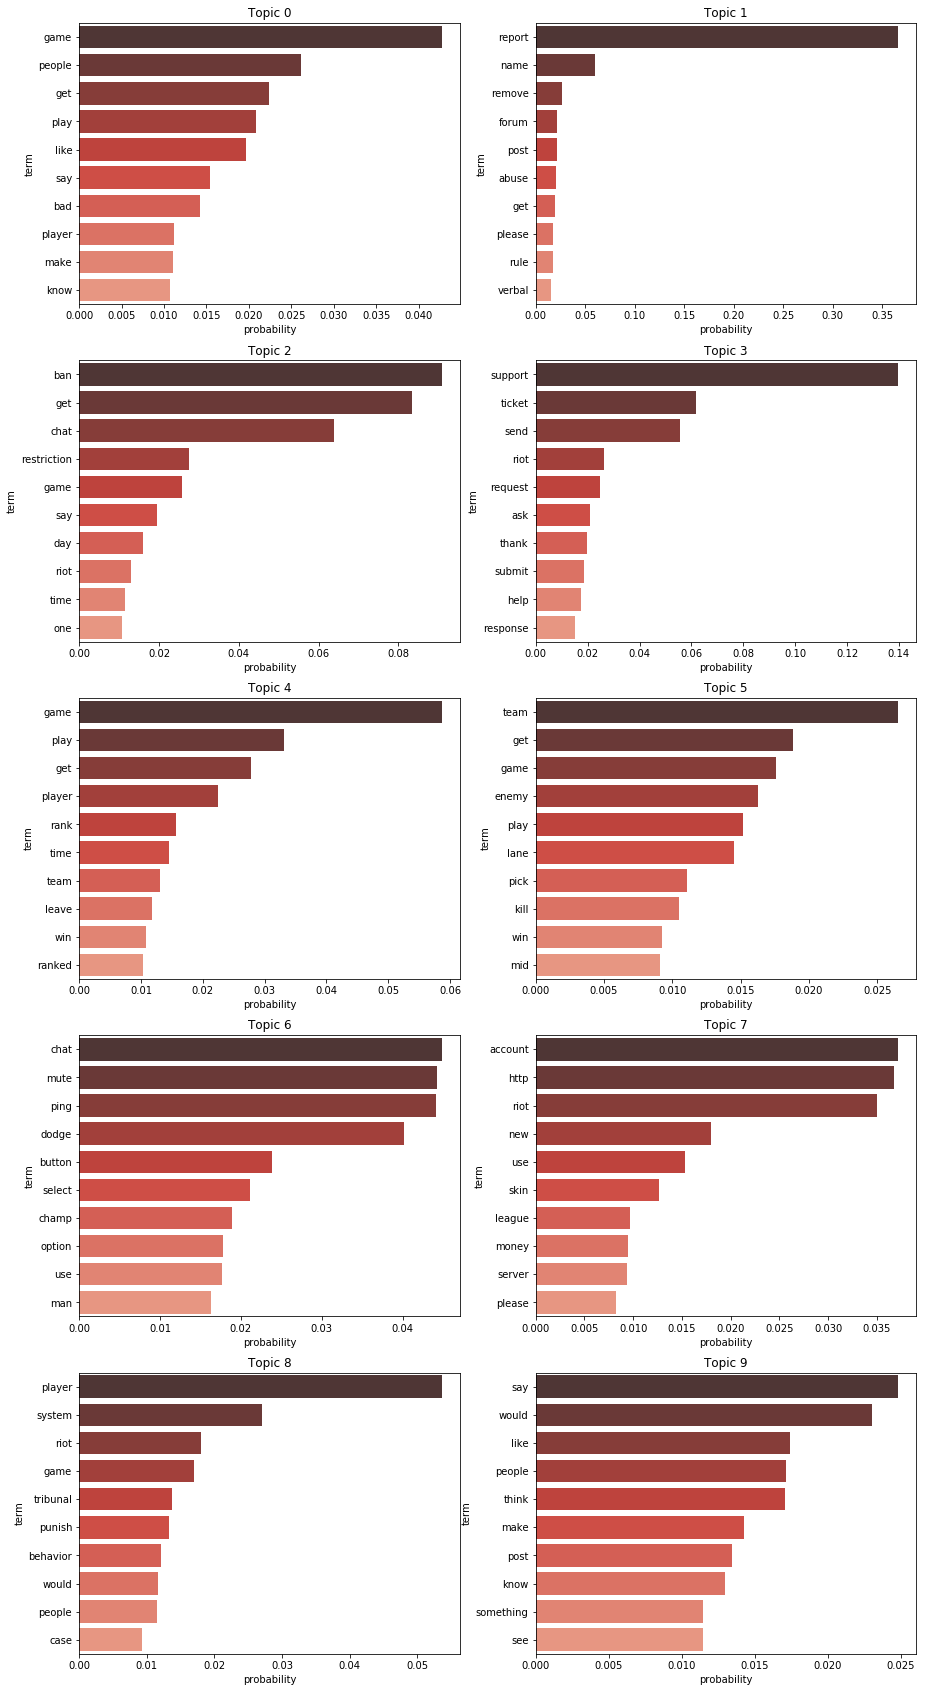

In [249]:
fiz=plt.figure(figsize=(15,30))
for i in range(10):
    df=pd.DataFrame(ldamodel.show_topic(i), columns=['term','prob']).set_index('term')
    plt.subplot(5,2,i+1)
    plt.title('Topic '+str(i))
    sns.barplot(x='prob', y=df.index, data=df,  palette='Reds_d')
    plt.xlabel('probability')
plt.savefig("topics.png")
plt.show()